<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/Starting_final_project_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lats & lons for the Sahel region are based on Fig. 1 in this article: https://journals.ametsoc.org/jcli/article/15/24/3615/29069

Ask Jenny about longitude indexing to see whether there's soemthing wrong with what I'm doing.

In [7]:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/images'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

Mounted at /content/gdrive


In [8]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [9]:
from datetime import date, timedelta
import netCDF4 as nc
ssp585 = df.query("variable_id == 'pr' & experiment_id == 'ssp585' & institution_id == 'NCAR'")

In [10]:
x = ssp585.query("member_id == 'r4i1p1f1' & table_id == 'Amon' & source_id == 'CESM2'")

In [11]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = x.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
pr = ds.pr.sel(lat=slice(11.25,18.75))
pr = pr.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True)
lat = ds.lat.sel(lat=slice(11.25,18.75))
lon = ds.lon.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True) # Not sure exactly what drop means, but I think it doesn't matter

# Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
def is_djf(month):
  return (month>=12) | ((month>=1) & (month<=2))
def is_mam(month):
  return (month>=3) & (month<=5)
def is_jja(month):
  return (month>=6) & (month<=8)
def is_son(month):
  return (month>=9) & (month<=11)
pr_djf = pr.sel(time=is_djf(pr['time.month']))
pr_mam = pr.sel(time=is_mam(pr['time.month']))
pr_jja = pr.sel(time=is_jja(pr['time.month']))
pr_son = pr.sel(time=is_son(pr['time.month']))


pr_allseasons = {
    'DJF': pr_djf,
    'MAM': pr_mam,
    'JJA': pr_jja,
    'SON': pr_son
}
# Splitting it up by decade:
decades = np.arange(2010, 2110, 10)
decade_list = [] # I'll use decade_list for graphing.
for i in range(len(decades)):
  if i<(len(decades)-1):
    decade_list.append(str(decades[i])+'-'+str(decades[i+1]))
decade_list[0] = '2015-2020'

def in_decade(minyear, maxyear, year):
  return (year>=minyear) & (year<maxyear)
pr_FINAL = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
for j in pr_allseasons.keys():
  for i in range(1, len(decades)):
    pr_FINAL[j].append(pr_allseasons[j].sel(time=in_decade(decades[i-1], decades[i], pr_allseasons[j]['time.year'])))

In [12]:
keyslist = ['DJF', 'MAM', 'JJA', 'SON']
time_avg_dict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
map_dict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
for season in keyslist:
  for i in range(9):
    a = pr_FINAL[season][i].mean(axis=1)
    time_avg_dict[season].append(a.mean(axis=1))
    map_dict[season].append(pr_FINAL[season][i].mean(axis=0))

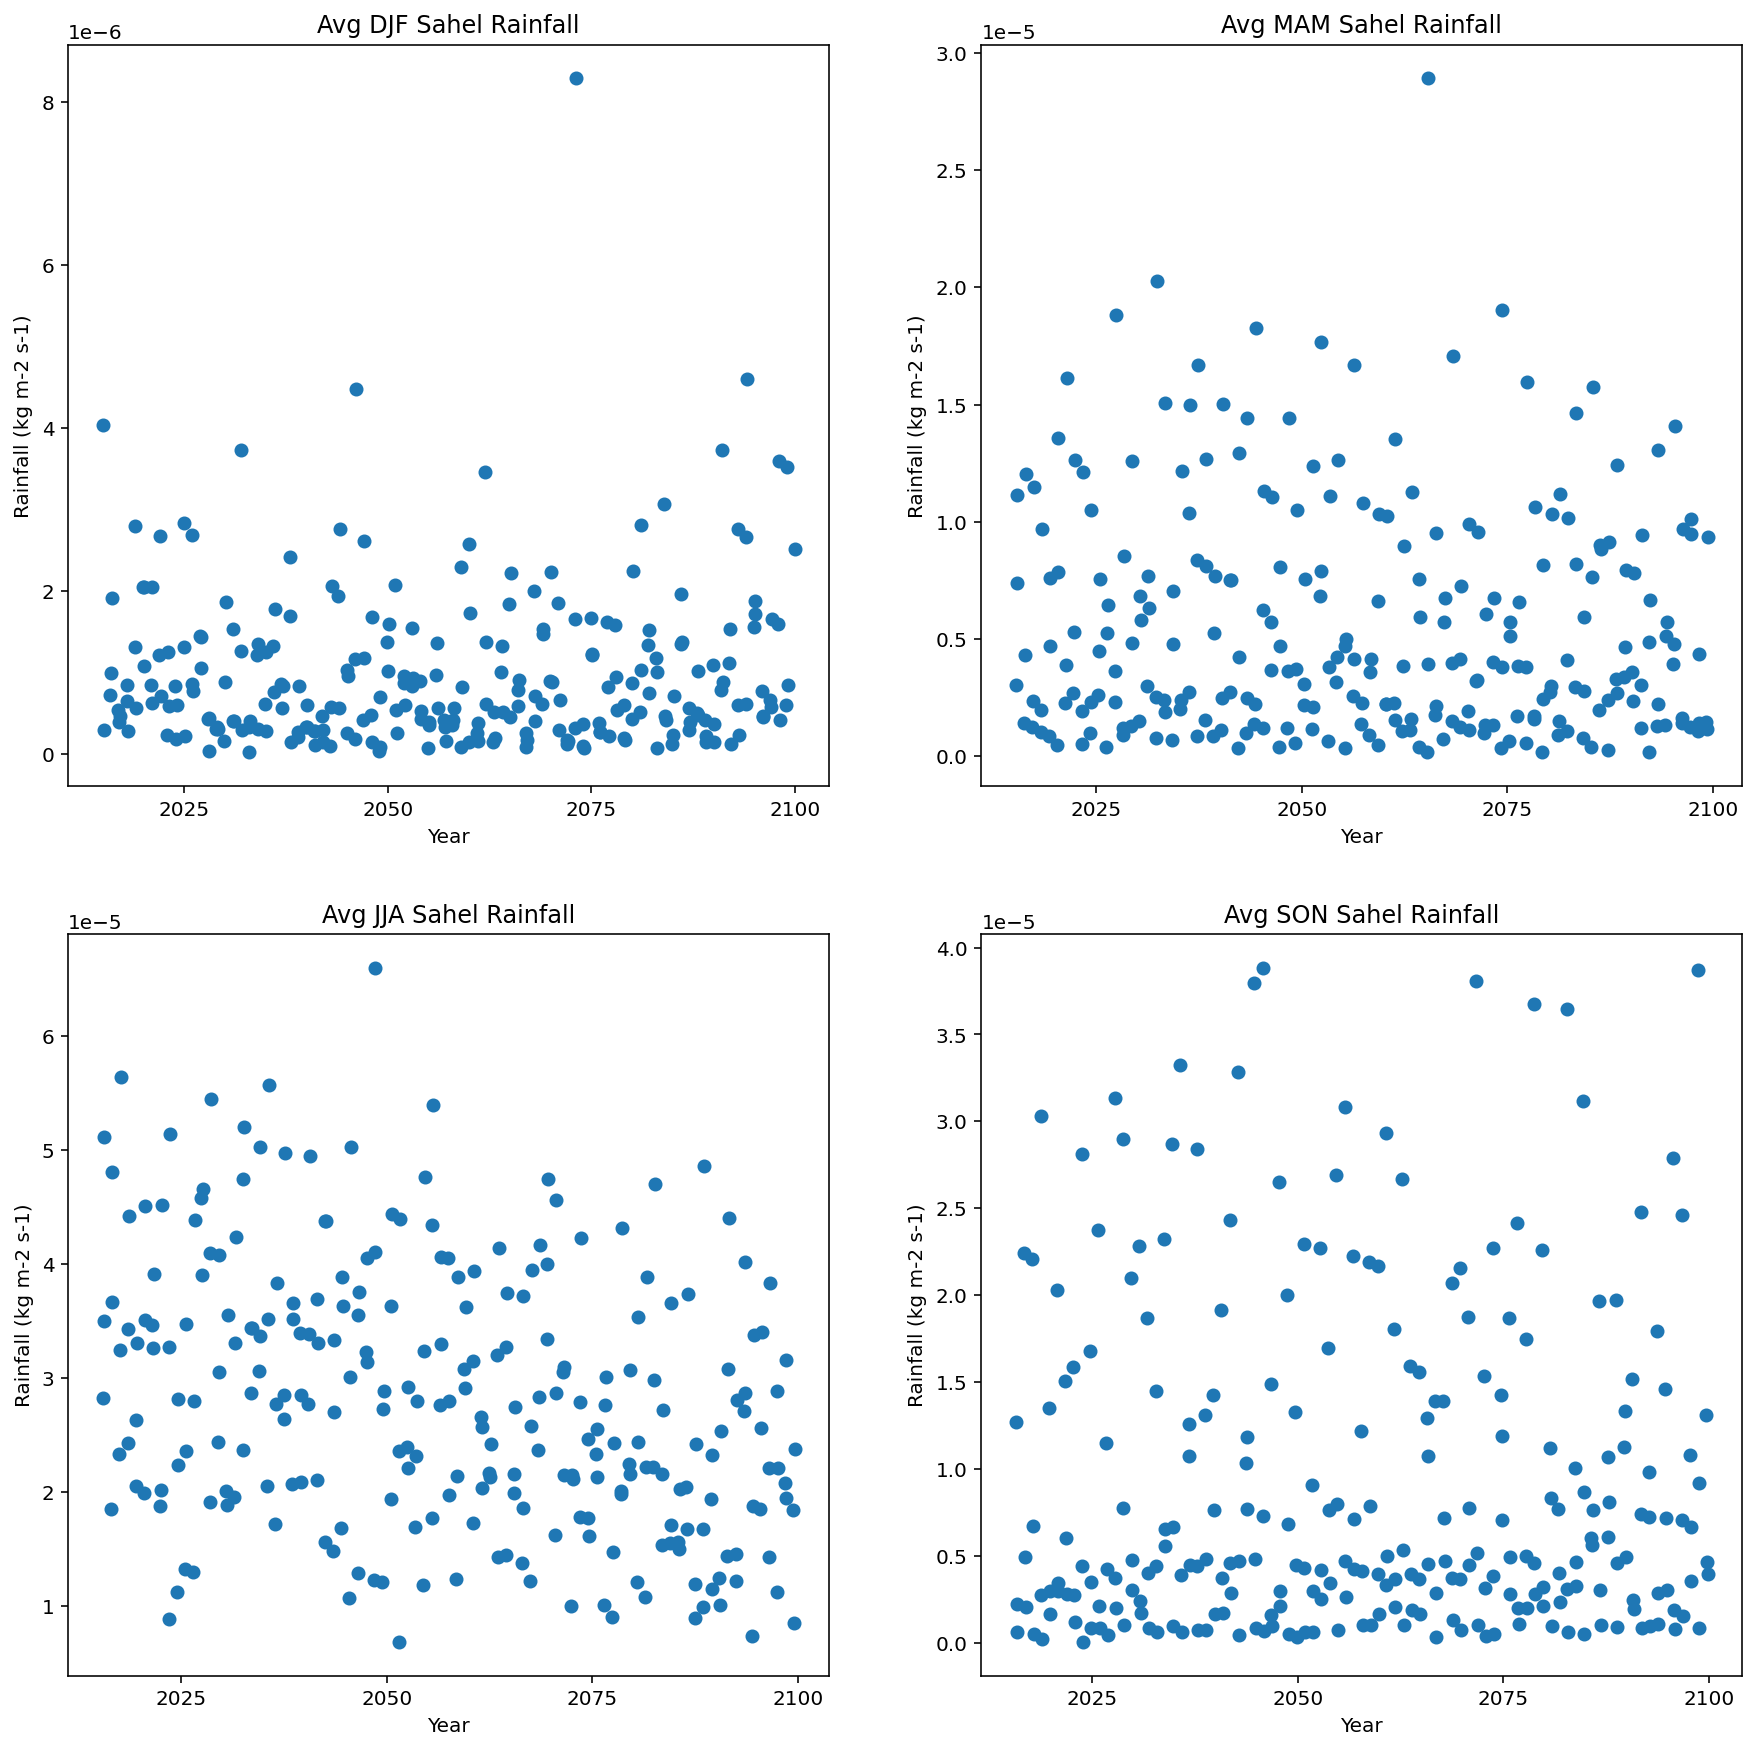

In [19]:
fig2, axarr2 = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axlist2 = axarr2.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html

time_avgs_concat = {}
for season in keyslist:
  time_avgs_concat[season] = xr.concat([i for i in time_avg_dict[season]], 'time')
for i in range(4):
  axlist2[i].plot(time_avgs_concat[keyslist[i]].time, time_avgs_concat[keyslist[i]], 'o')
  axlist2[i].set_title("Avg "+keyslist[i]+" Sahel Rainfall")
  axlist2[i].set_xlabel("Year")
  axlist2[i].set_ylabel("Rainfall ("+pr.units+")")
plt.savefig(f"{images_dir}/scatter_plots1.png")
plt.show()

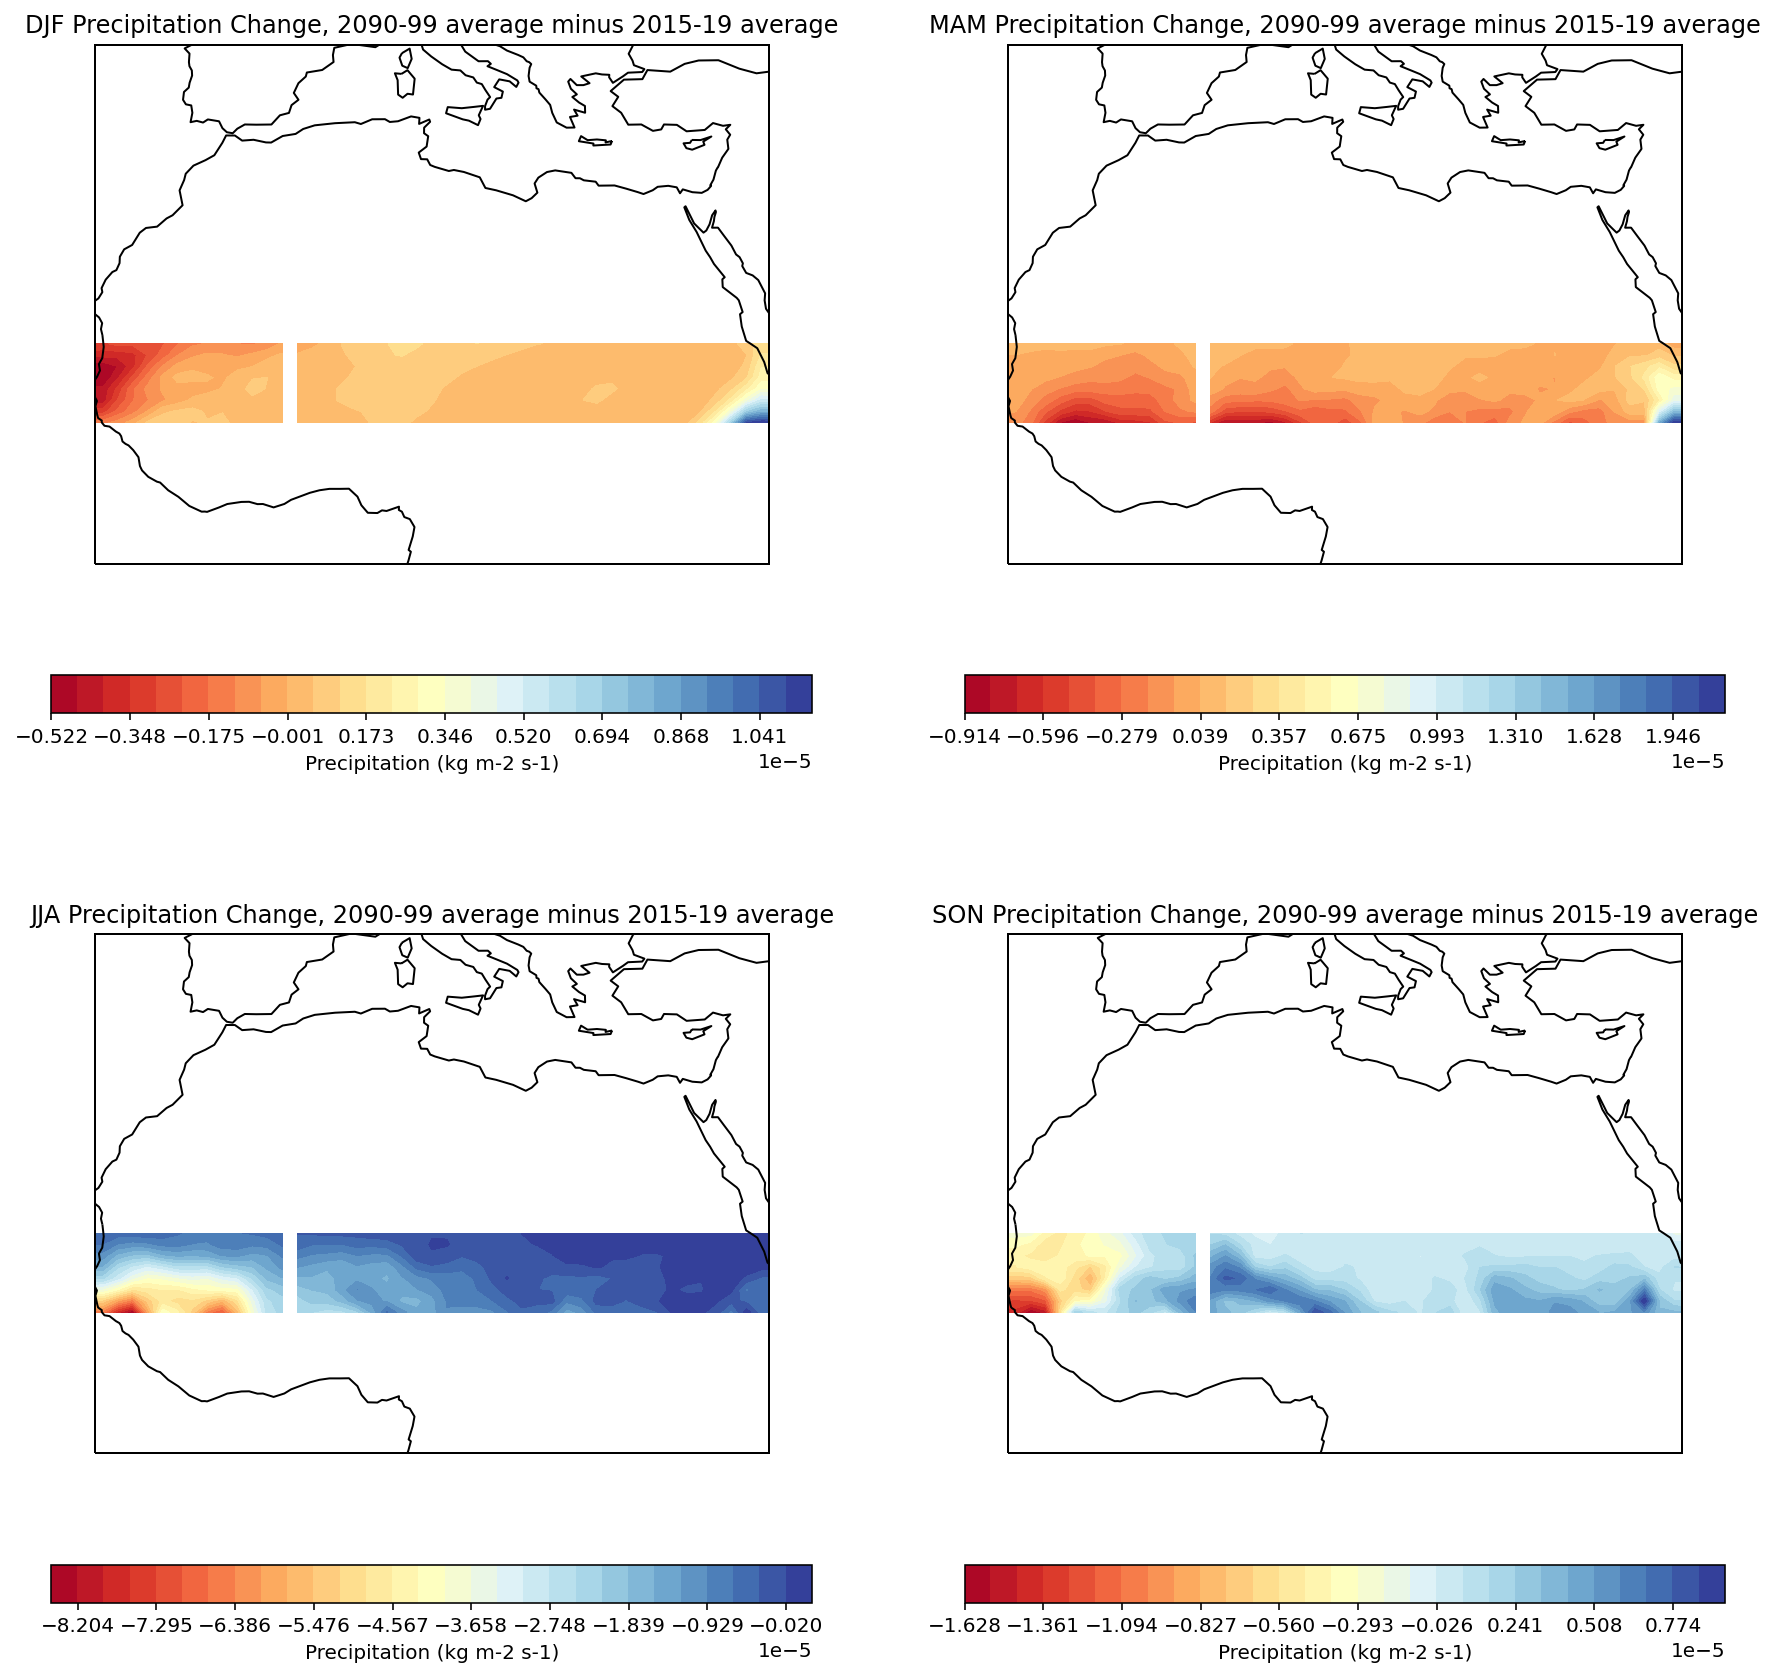

In [20]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axlist = axarr.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
for i in range(4):
  pr_start = map_dict[keyslist[i]][0]
  pr_end = map_dict[keyslist[i]][-1]
  diff = pr_end-pr_start

  maxlist = []
  minlist = []
  for j in diff.values:
    maxlist.append(np.max(j))
    minlist.append(np.min(j))
  min = np.min(minlist)
  max = np.max(maxlist)
  
  cmap1 = plt.cm.RdYlBu
  
  levels = np.linspace(min, max, 30)
  cs=axlist[i].contourf(lon, lat, diff,levels,
                transform=ccrs.PlateCarree(),
                cmap=cmap1)
  axlist[i].coastlines()
  axlist[i].set_extent([-16.88, 39.38, 0, 40]) # longitude latitude extent
  cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
  cbar.set_label('Precipitation ('+pr.units+')')
  axlist[i].set_title(keyslist[i]+' Precipitation Change, 2090-99 average minus 2015-19 average')
plt.savefig(f"{images_dir}/difference_maps.png")
plt.show()